In [2]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_laplace
from skimage.filters import threshold_otsu
from skimage import exposure
import matplotlib.pyplot as plt

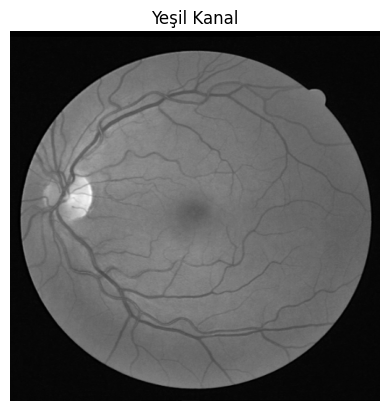

In [3]:
img = cv2.imread(r"C:\dersler\goruntuisleme\IPProje\goruntuler\images\0.png")
green = img[:, :, 1]
plt.imshow(green , cmap='gray')
plt.title("Yeşil Kanal")
plt.axis('off')
plt.show()

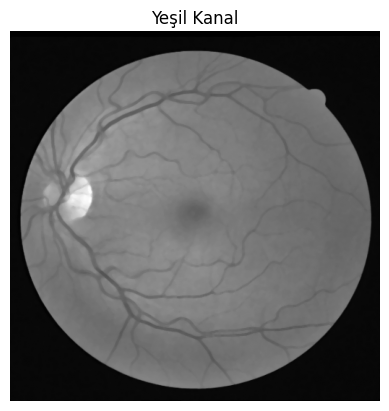

In [4]:
def median_filter(image, kernel_size=3):
    
    pad_size = kernel_size // 2
    padded_image = np.pad(image, pad_size, mode='constant', constant_values=0)
    filtered_image = np.zeros_like(image)

    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            kernel_region = padded_image[i:i + kernel_size, j:j + kernel_size]
            filtered_image[i, j] = np.median(kernel_region)
    return filtered_image

#3. median filtre ile gürültü giderme
median_filtered =median_filter(green,5)

plt.imshow(median_filtered , cmap='gray')
plt.title("Yeşil Kanal")
plt.axis('off')
plt.show()

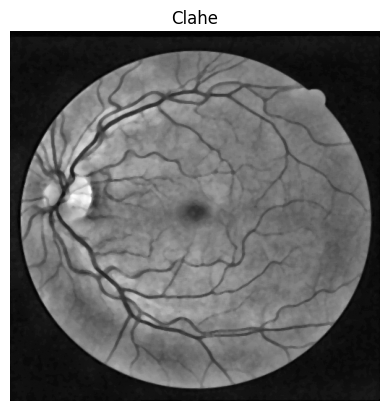

In [5]:
# CLAHE uygulama
clahe = cv2.createCLAHE(clipLimit=4.0, tileGridSize=(16,16))
clahe_img = clahe.apply(median_filtered)

plt.imshow(clahe_img , cmap='gray')
plt.title("Clahe")
plt.axis('off')
plt.show()

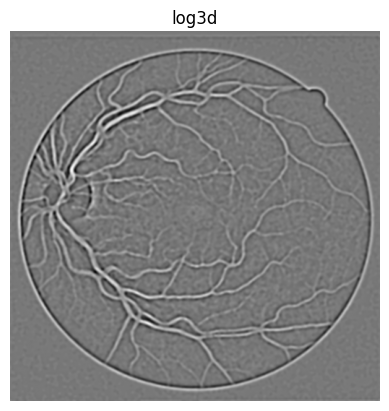

In [6]:
def create_log3d_filter(sigma_x=1.8, sigma_y=1.8, size=15):
    """3D LoG filtresi oluştur"""
    x = np.linspace(-size//2, size//2, size)
    y = np.linspace(-size//2, size//2, size)
    X, Y = np.meshgrid(x, y)
    
    # LoG formülü
    log_filter = -(1/(2*np.pi*sigma_x*sigma_y)) * (
        2 - (X*2/sigma_x*2 + Y*2/sigma_y*2)
    ) * np.exp(-(X*2/(2*sigma_x*2) + Y*2/(2*sigma_y*2)))
    
    return log_filter


def apply_log3d(img, sigma_x=1.8, sigma_y=1.8):
    """3D LoG filtresini uygula"""
    # Görüntüyü float32'ye çevir
    img_float = img.astype(np.float32)
    
    # LoG filtresini uygula
    log_response = gaussian_laplace(img_float, sigma=[sigma_y, sigma_x])
    
    # Normalize et ve uint8'e çevir
    log_response = cv2.normalize(log_response, None, 0, 255, cv2.NORM_MINMAX)
    log_response = np.uint8(log_response)
    
    return log_response

img_log = apply_log3d(clahe_img , sigma_x=1.8, sigma_y=1.8)

plt.imshow(img_log , cmap='gray')
plt.title("log3d")
plt.axis('off')
plt.show()

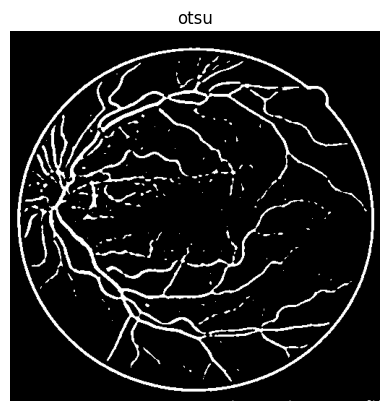

In [7]:
level = threshold_otsu(img_log)
img_otsu= img_log > level
img_otsu =exposure.rescale_intensity(img_otsu, out_range=(0, 255)).astype(np.uint8)

plt.imshow(img_otsu , cmap='gray')
plt.title("otsu")
plt.axis('off')
plt.show()

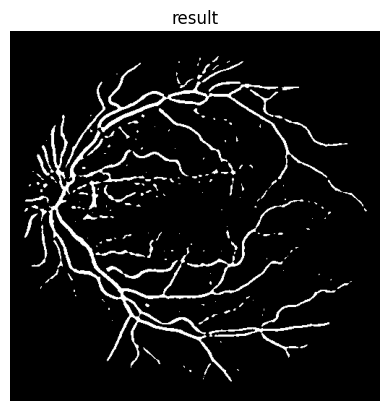

In [8]:
def get_edges(img):
    ret,thresh1=cv2.threshold(img,25,255,cv2.THRESH_BINARY )
    edge=cv2.Canny(thresh1, 50, 150)
    kernel = np.ones((7,7), np.uint8)
    edge= cv2.dilate(edge, kernel, iterations=1)
    edge=cv2.add(edge,255-thresh1)
    return edge

son = cv2.subtract(img_otsu ,get_edges(green))

plt.imshow(son , cmap='gray')
plt.title("result")
plt.axis('off')
plt.show()

0.48909657320872274


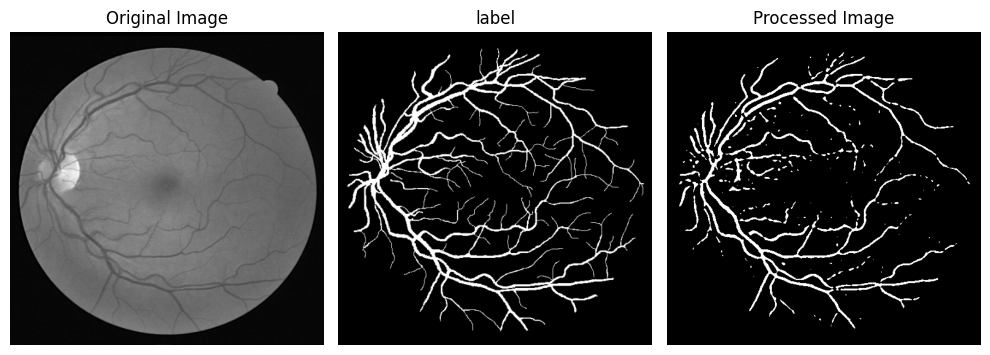

In [9]:
def calculate_iou(pred, label):
    intersection = np.logical_and(pred, label).sum()
    union = np.logical_or(pred, label).sum()
    return intersection / union if union != 0 else 0

label= cv2.imread(r"C:\dersler\goruntuisleme\IPProje\goruntuler\labels\0.png")
label=label[:, :, 1]
print(calculate_iou(son, label))

# Visualizing the result
plt.figure(figsize=(10, 8))

plt.subplot(1, 3, 1)
plt.imshow(green, cmap='gray')
plt.title("Original Image")
plt.axis('off')

plt.subplot(1, 3, 2)
plt.imshow(label, cmap='gray')
plt.title("label")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(son, cmap='gray')
plt.title("Processed Image")
plt.axis('off')

plt.tight_layout()
plt.show()